In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Библиотеки импортированы")

✓ Библиотеки импортированы


## 1. Загрузка данных

In [2]:
df = pd.read_csv('../data/processed/anime_processed.csv')

print(f"Размер датасета: {df.shape}")
print(f"\nПервые строки:")
df.head()

Размер датасета: (24718, 24)

Первые строки:


Первые строки:


,anime_id,Name,English name,Other name,Score,Genres,Synopsis,Type,Episodes,Aired,...,Studios,Source,Duration,Rating,Rank,Popularity,Favorites,Scored By,Members,Image URL
0,1,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,8.75,"Action, Award Winning, Sci-Fi","Crime is timeless. By the year 2071, humanity ...",TV,26.0,1998-04-03,...,Sunrise,Original,24 min per ep,R - 17+ (violence & profanity),41.0,43,78525,914193.0,1771505,https://cdn.myanimelist.net/images/anime/4/196...
1,5,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop: The Movie,カウボーイビバップ 天国の扉,8.38,"Action, Sci-Fi","Another day, another bounty—such is the life o...",Movie,1.0,2001-09-01,...,Bones,Original,1 hr 55 min,R - 17+ (violence & profanity),189.0,602,1448,206248.0,360978,https://cdn.myanimelist.net/images/anime/1439/...
2,6,Trigun,Trigun,トライガン,8.22,"Action, Adventure, Sci-Fi","Vash the Stampede is the man with a $$60,000,0...",TV,26.0,1998-04-01,...,Madhouse,Manga,24 min per ep,PG-13 - Teens 13 or older,328.0,246,15035,356739.0,727252,https://cdn.myanimelist.net/images/anime/7/203...
3,7,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),7.25,"Action, Drama, Mystery, Supernatural",Robin Sena is a powerful craft user drafted in...,TV,26.0,2002-07-03,...,Sunrise,Original,25 min per ep,PG-13 - Teens 13 or older,2764.0,1795,613,42829.0,111931,https://cdn.myanimelist.net/images/anime/10/19...
4,8,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,6.94,"Adventure, Fantasy, Supernatural",It is the dark century and the people are suff...,TV,52.0,2004-09-30,...,Toei Animation,Manga,23 min per ep,PG - Children,4240.0,5126,14,6413.0,15001,https://cdn.myanimelist.net/images/anime/7/215...


## 2. Подготовка признаков (только pre-release данные)

### Что включаем:
- ✅ Episodes - количество эпизодов (обычно известно заранее)
- ✅ Жанры - известны при анонсе
- ✅ Type, Status, Source, Rating - известны до релиза

### Что НЕ включаем:
- ❌ Favorites - добавляются после просмотра
- ❌ Scored By - количество оценок (известно после релиза)
- ❌ Members - количество участников (растет со временем)
- ❌ Rank - зависит от Score
- ❌ Popularity - зависит от Members

In [3]:
target = 'Score'
df_model = df[df[target].notna()].copy()

print(f"Количество записей с известным рейтингом: {len(df_model)}")

Количество записей с известным рейтингом: 24718


In [4]:
# Числовые признаки (доступные до релиза)
numeric_features = ['Episodes']

# Категориальные признаки
categorical_features = ['Type', 'Status', 'Source', 'Rating']

print(f"Числовые признаки ({len(numeric_features)}): {numeric_features}")
print(f"Категориальные признаки ({len(categorical_features)}): {categorical_features}")

Числовые признаки (1): ['Episodes']
Категориальные признаки (4): ['Type', 'Status', 'Source', 'Rating']


### Извлечение информации о жанрах

Жанры хранятся в виде строки с разделителями-запятыми. Извлекаем топ-20 наиболее популярных жанров и создаем для каждого бинарный признак.

In [5]:
print("Извлечение информации о жанрах...")

# Разделяем жанры и считаем частоту
all_genres = []
for genres_str in df_model['Genres'].dropna():
    genres_list = [g.strip() for g in str(genres_str).split(',')]
    all_genres.extend(genres_list)

genre_counts = Counter(all_genres)
top_genres = [genre for genre, count in genre_counts.most_common(20)]

print(f"Топ-20 жанров:")
for i, (genre, count) in enumerate(genre_counts.most_common(20), 1):
    print(f"  {i}. {genre}: {count}")

Извлечение информации о жанрах...
Топ-20 жанров:
  1. Comedy: 7116
  2. Fantasy: 5258
  3. UNKNOWN: 4859
  4. Action: 4689
  5. Adventure: 3820
  6. Sci-Fi: 3080
  7. Drama: 2823
  8. Romance: 2044
  9. Slice of Life: 1746
  10. Supernatural: 1485
  11. Hentai: 1483
  12. Mystery: 842
  13. Avant Garde: 795
  14. Ecchi: 793
  15. Sports: 766
  16. Horror: 530
  17. Award Winning: 240
  18. Suspense: 240
  19. Boys Love: 164
  20. Gourmet: 145


In [6]:
# Создаем бинарные признаки для топ-жанров
for genre in top_genres:
    df_model[f'Genre_{genre}'] = df_model['Genres'].apply(
        lambda x: 1 if genre in str(x) else 0
    )

genre_features = [f'Genre_{genre}' for genre in top_genres]

print(f"\n✓ Создано {len(genre_features)} бинарных признаков для жанров")


✓ Создано 20 бинарных признаков для жанров



## 3. Обработка пропущенных значений

In [7]:
# Заполняем пропуски в Episodes медианой
if df_model['Episodes'].isna().sum() > 0:
    print(f"Пропуски в Episodes: {df_model['Episodes'].isna().sum()}")
    df_model['Episodes'].fillna(df_model['Episodes'].median(), inplace=True)

for col in categorical_features:
    missing = df_model[col].isna().sum()
    if missing > 0:
        print(f"Пропуски в {col}: {missing}")
        df_model[col].fillna(df_model[col].mode()[0], inplace=True)

print("✓ Пропуски обработаны")

✓ Пропуски обработаны


## 4. Кодирование категориальных признаков

In [8]:
# LabelEncoder для Rating (порядковый признак)
rating_order = ['G - All Ages', 'PG - Children', 'PG-13 - Teens 13 or older', 
                'R - 17+ (violence & profanity)', 'R+ - Mild Nudity', 'Rx - Hentai']
le_rating = LabelEncoder()
le_rating.fit(rating_order)
df_model['Rating_encoded'] = df_model['Rating'].apply(
    lambda x: le_rating.transform([x])[0] if x in rating_order else -1
)

print("Кодирование Rating (LabelEncoder):")
for i, val in enumerate(rating_order):
    print(f"  {i}: {val}")

Кодирование Rating (LabelEncoder):
  0: G - All Ages
  1: PG - Children
  2: PG-13 - Teens 13 or older
  3: R - 17+ (violence & profanity)
  4: R+ - Mild Nudity
  5: Rx - Hentai


In [9]:
# One-Hot Encoding для остальных категориальных признаков
categorical_to_encode = ['Type', 'Status', 'Source']
df_encoded = pd.get_dummies(df_model, columns=categorical_to_encode, prefix=categorical_to_encode)

print(f"\nOne-Hot Encoding применен к: {categorical_to_encode}")
print(f"Количество признаков после кодирования: {df_encoded.shape[1]}")


One-Hot Encoding применен к: ['Type', 'Status', 'Source']
Количество признаков после кодирования: 69


In [10]:
# Формирование итогового набора признаков
feature_columns = numeric_features + ['Rating_encoded'] + genre_features
one_hot_columns = [col for col in df_encoded.columns 
                   if any(col.startswith(prefix + '_') for prefix in categorical_to_encode)]
feature_columns.extend(one_hot_columns)

X = df_encoded[feature_columns]
y = df_encoded[target]

print(f"Итоговое количество признаков: {len(feature_columns)}")
print(f"  - Числовые: {len(numeric_features)}")
print(f"  - Rating (encoded): 1")
print(f"  - Жанры: {len(genre_features)}")
print(f"  - One-Hot encoded: {len(one_hot_columns)}")
print(f"\nРазмер X: {X.shape}, размер y: {y.shape}")

Итоговое количество признаков: 49
  - Числовые: 1
  - Rating (encoded): 1
  - Жанры: 20
  - One-Hot encoded: 27

Размер X: (24718, 49), размер y: (24718,)


## 5. Стандартизация числовых признаков

In [11]:
scaler = StandardScaler()
X_scaled = X.copy()

# Масштабируем только Episodes
numeric_indices = [feature_columns.index(col) for col in numeric_features]
X_scaled.iloc[:, numeric_indices] = scaler.fit_transform(X.iloc[:, numeric_indices])

print("Стандартизация применена к: Episodes")
print(f"\nДо: mean={X['Episodes'].mean():.2f}, std={X['Episodes'].std():.2f}")
print(f"После: mean={X_scaled['Episodes'].mean():.2f}, std={X_scaled['Episodes'].std():.2f}")

Стандартизация применена к: Episodes

До: mean=14.66, std=48.20
После: mean=0.00, std=1.00


## 6. Разделение данных на train/test

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"\nРаспределение Score:")
print(f"  Train: mean={y_train.mean():.2f}, std={y_train.std():.2f}")
print(f"  Test:  mean={y_test.mean():.2f}, std={y_test.std():.2f}")

Размер обучающей выборки: (19774, 49)
Размер тестовой выборки: (4944, 49)

Распределение Score:
  Train: mean=6.39, std=0.74
  Test:  mean=6.37, std=0.74


## 7. Обучение и сравнение моделей

Используем те же 4 модели для сравнения с Экспериментом 1.

In [13]:
results = {}

In [14]:
# Модель 1: Linear Regression
print("Обучение модели: Linear Regression")

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred_train_lr = lr_model.predict(X_train)
y_pred_test_lr = lr_model.predict(X_test)

lr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_lr))
lr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
lr_mae_train = mean_absolute_error(y_train, y_pred_train_lr)
lr_mae_test = mean_absolute_error(y_test, y_pred_test_lr)
lr_r2_train = r2_score(y_train, y_pred_train_lr)
lr_r2_test = r2_score(y_test, y_pred_test_lr)

print(f"RMSE: Train={lr_rmse_train:.4f}, Test={lr_rmse_test:.4f}")
print(f"MAE:  Train={lr_mae_train:.4f}, Test={lr_mae_test:.4f}")
print(f"R²:   Train={lr_r2_train:.4f}, Test={lr_r2_test:.4f}")

results['Linear Regression'] = {
    'model': lr_model,
    'rmse_train': lr_rmse_train, 'rmse_test': lr_rmse_test,
    'mae_train': lr_mae_train, 'mae_test': lr_mae_test,
    'r2_train': lr_r2_train, 'r2_test': lr_r2_test,
    'predictions': y_pred_test_lr
}

Обучение модели: Linear Regression
RMSE: Train=0.6322, Test=0.6384
MAE:  Train=0.4646, Test=0.4711
R²:   Train=0.2696, Test=0.2574


In [15]:
# Модель 2: Decision Tree
print("Обучение модели: Decision Tree")

dt_model = DecisionTreeRegressor(max_depth=8, min_samples_split=30, random_state=42)
dt_model.fit(X_train, y_train)

y_pred_train_dt = dt_model.predict(X_train)
y_pred_test_dt = dt_model.predict(X_test)

dt_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_dt))
dt_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_dt))
dt_mae_train = mean_absolute_error(y_train, y_pred_train_dt)
dt_mae_test = mean_absolute_error(y_test, y_pred_test_dt)
dt_r2_train = r2_score(y_train, y_pred_train_dt)
dt_r2_test = r2_score(y_test, y_pred_test_dt)

print(f"RMSE: Train={dt_rmse_train:.4f}, Test={dt_rmse_test:.4f}")
print(f"MAE:  Train={dt_mae_train:.4f}, Test={dt_mae_test:.4f}")
print(f"R²:   Train={dt_r2_train:.4f}, Test={dt_r2_test:.4f}")

results['Decision Tree'] = {
    'model': dt_model,
    'rmse_train': dt_rmse_train, 'rmse_test': dt_rmse_test,
    'mae_train': dt_mae_train, 'mae_test': dt_mae_test,
    'r2_train': dt_r2_train, 'r2_test': dt_r2_test,
    'predictions': y_pred_test_dt
}

Обучение модели: Decision Tree
RMSE: Train=0.6056, Test=0.6166
MAE:  Train=0.4297, Test=0.4399
R²:   Train=0.3297, Test=0.3073
RMSE: Train=0.6056, Test=0.6166
MAE:  Train=0.4297, Test=0.4399
R²:   Train=0.3297, Test=0.3073


In [16]:
# Модель 3: Random Forest
print("Обучение модели: Random Forest")

rf_model = RandomForestRegressor(n_estimators=150, max_depth=12, min_samples_split=15,
                                  random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

y_pred_train_rf = rf_model.predict(X_train)
y_pred_test_rf = rf_model.predict(X_test)

rf_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
rf_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))
rf_mae_train = mean_absolute_error(y_train, y_pred_train_rf)
rf_mae_test = mean_absolute_error(y_test, y_pred_test_rf)
rf_r2_train = r2_score(y_train, y_pred_train_rf)
rf_r2_test = r2_score(y_test, y_pred_test_rf)

print(f"RMSE: Train={rf_rmse_train:.4f}, Test={rf_rmse_test:.4f}")
print(f"MAE:  Train={rf_mae_train:.4f}, Test={rf_mae_test:.4f}")
print(f"R²:   Train={rf_r2_train:.4f}, Test={rf_r2_test:.4f}")

results['Random Forest'] = {
    'model': rf_model,
    'rmse_train': rf_rmse_train, 'rmse_test': rf_rmse_test,
    'mae_train': rf_mae_train, 'mae_test': rf_mae_test,
    'r2_train': rf_r2_train, 'r2_test': rf_r2_test,
    'predictions': y_pred_test_rf
}

Обучение модели: Random Forest
RMSE: Train=0.5501, Test=0.5878
MAE:  Train=0.3905, Test=0.4175
R²:   Train=0.4469, Test=0.3704
RMSE: Train=0.5501, Test=0.5878
MAE:  Train=0.3905, Test=0.4175
R²:   Train=0.4469, Test=0.3704


In [17]:
# Модель 4: Gradient Boosting
print("Обучение модели: Gradient Boosting")

gb_model = GradientBoostingRegressor(n_estimators=150, max_depth=5, learning_rate=0.05,
                                      random_state=42)
gb_model.fit(X_train, y_train)

y_pred_train_gb = gb_model.predict(X_train)
y_pred_test_gb = gb_model.predict(X_test)

gb_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_gb))
gb_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_gb))
gb_mae_train = mean_absolute_error(y_train, y_pred_train_gb)
gb_mae_test = mean_absolute_error(y_test, y_pred_test_gb)
gb_r2_train = r2_score(y_train, y_pred_train_gb)
gb_r2_test = r2_score(y_test, y_pred_test_gb)

print(f"RMSE: Train={gb_rmse_train:.4f}, Test={gb_rmse_test:.4f}")
print(f"MAE:  Train={gb_mae_train:.4f}, Test={gb_mae_test:.4f}")
print(f"R²:   Train={gb_r2_train:.4f}, Test={gb_r2_test:.4f}")

results['Gradient Boosting'] = {
    'model': gb_model,
    'rmse_train': gb_rmse_train, 'rmse_test': gb_rmse_test,
    'mae_train': gb_mae_train, 'mae_test': gb_mae_test,
    'r2_train': gb_r2_train, 'r2_test': gb_r2_test,
    'predictions': y_pred_test_gb
}

Обучение модели: Gradient Boosting
RMSE: Train=0.5773, Test=0.5967
MAE:  Train=0.4152, Test=0.4293
R²:   Train=0.3909, Test=0.3512
RMSE: Train=0.5773, Test=0.5967
MAE:  Train=0.4152, Test=0.4293
R²:   Train=0.3909, Test=0.3512


## 8. Сводная таблица результатов

In [18]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE_Train': [results[m]['rmse_train'] for m in results.keys()],
    'RMSE_Test': [results[m]['rmse_test'] for m in results.keys()],
    'MAE_Train': [results[m]['mae_train'] for m in results.keys()],
    'MAE_Test': [results[m]['mae_test'] for m in results.keys()],
    'R2_Train': [results[m]['r2_train'] for m in results.keys()],
    'R2_Test': [results[m]['r2_test'] for m in results.keys()],
})

print("Сравнение моделей:")
comparison_df

Сравнение моделей:


,Model,RMSE_Train,RMSE_Test,MAE_Train,MAE_Test,R2_Train,R2_Test
0,Linear Regression,0.632172,0.638397,0.464602,0.471150,0.269607,0.257390
1,Decision Tree,0.605594,0.616575,0.429750,0.439864,0.329730,0.307291
2,Random Forest,0.550133,0.587816,0.390515,0.417522,0.446877,0.370404
3,Gradient Boosting,0.577321,0.596694,0.415178,0.429316,0.390856,0.351242


In [19]:
comparison_df.to_csv('results_pre_release.csv', index=False)
print("✓ Результаты сохранены")

✓ Результаты сохранены


## 9. Кросс-валидация

In [20]:
cv_results = {}

for name, result in results.items():
    model = result['model']
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, 
                                 scoring='neg_mean_squared_error', n_jobs=-1)
    cv_rmse = np.sqrt(-cv_scores)
    cv_results[name] = {
        'mean_cv_rmse': cv_rmse.mean(),
        'std_cv_rmse': cv_rmse.std()
    }
    print(f"{name}:")
    print(f"  CV RMSE: {cv_rmse.mean():.4f} (+/- {cv_rmse.std():.4f})")

Linear Regression:
  CV RMSE: 0.6337 (+/- 0.0143)
Decision Tree:
  CV RMSE: 0.6291 (+/- 0.0149)
Decision Tree:
  CV RMSE: 0.6291 (+/- 0.0149)
Random Forest:
  CV RMSE: 0.5984 (+/- 0.0111)
Random Forest:
  CV RMSE: 0.5984 (+/- 0.0111)
Gradient Boosting:
  CV RMSE: 0.5975 (+/- 0.0129)
Gradient Boosting:
  CV RMSE: 0.5975 (+/- 0.0129)


## 10. Анализ важности признаков

In [21]:
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Топ-20 наиболее важных признаков:")
feature_importance.head(20)

Топ-20 наиболее важных признаков:


,feature,importance
0,Episodes,0.165275
1,Rating_encoded,0.153905
37,Source_Manga,0.138954
27,Type_TV,0.046473
8,Genre_Drama,0.044285
22,Type_Movie,0.042675
14,Genre_Avant Garde,0.040711
36,Source_Light novel,0.038345
24,Type_ONA,0.028003
45,Source_Unknown,0.024267


In [22]:
feature_importance.to_csv('feature_importance_pre_release.csv', index=False)
print("✓ Важность признаков сохранена")

✓ Важность признаков сохранена


In [23]:
# Анализ важности по категориям
print("Важность по категориям:")
genre_importance = feature_importance[feature_importance['feature'].str.startswith('Genre_')]['importance'].sum()
type_importance = feature_importance[feature_importance['feature'].str.startswith('Type_')]['importance'].sum()
source_importance = feature_importance[feature_importance['feature'].str.startswith('Source_')]['importance'].sum()
status_importance = feature_importance[feature_importance['feature'].str.startswith('Status_')]['importance'].sum()
episodes_importance = feature_importance[feature_importance['feature'] == 'Episodes']['importance'].sum()
rating_importance = feature_importance[feature_importance['feature'] == 'Rating_encoded']['importance'].sum()

category_importance = pd.DataFrame({
    'Category': ['Жанры', 'Тип (Type)', 'Источник (Source)', 'Статус', 'Количество эпизодов', 'Возрастной рейтинг'],
    'Importance': [genre_importance, type_importance, source_importance, status_importance, episodes_importance, rating_importance]
}).sort_values('Importance', ascending=False)

category_importance

Важность по категориям:


,Category,Importance
0,Жанры,0.280328
2,Источник (Source),0.249339
4,Количество эпизодов,0.165275
5,Возрастной рейтинг,0.153905
1,Тип (Type),0.135784
3,Статус,0.015369


## 11. Визуализация результатов

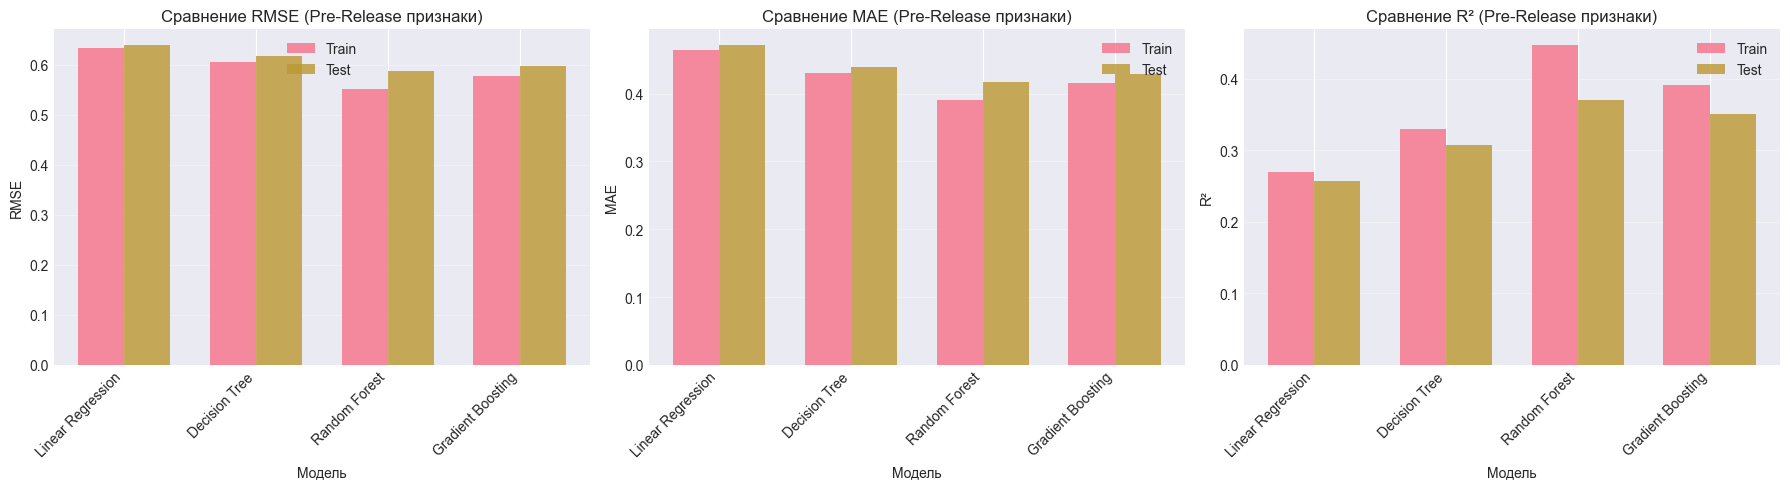

✓ График сохранен


In [24]:
# График 1: Сравнение метрик
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = list(results.keys())
rmse_train = [results[m]['rmse_train'] for m in models]
rmse_test = [results[m]['rmse_test'] for m in models]
mae_train = [results[m]['mae_train'] for m in models]
mae_test = [results[m]['mae_test'] for m in models]
r2_train = [results[m]['r2_train'] for m in models]
r2_test = [results[m]['r2_test'] for m in models]

x = np.arange(len(models))
width = 0.35

axes[0].bar(x - width/2, rmse_train, width, label='Train', alpha=0.8)
axes[0].bar(x + width/2, rmse_test, width, label='Test', alpha=0.8)
axes[0].set_xlabel('Модель')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Сравнение RMSE (Pre-Release признаки)')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, rotation=45, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(x - width/2, mae_train, width, label='Train', alpha=0.8)
axes[1].bar(x + width/2, mae_test, width, label='Test', alpha=0.8)
axes[1].set_xlabel('Модель')
axes[1].set_ylabel('MAE')
axes[1].set_title('Сравнение MAE (Pre-Release признаки)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

axes[2].bar(x - width/2, r2_train, width, label='Train', alpha=0.8)
axes[2].bar(x + width/2, r2_test, width, label='Test', alpha=0.8)
axes[2].set_xlabel('Модель')
axes[2].set_ylabel('R²')
axes[2].set_title('Сравнение R² (Pre-Release признаки)')
axes[2].set_xticks(x)
axes[2].set_xticklabels(models, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_metrics_pre_release.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ График сохранен")

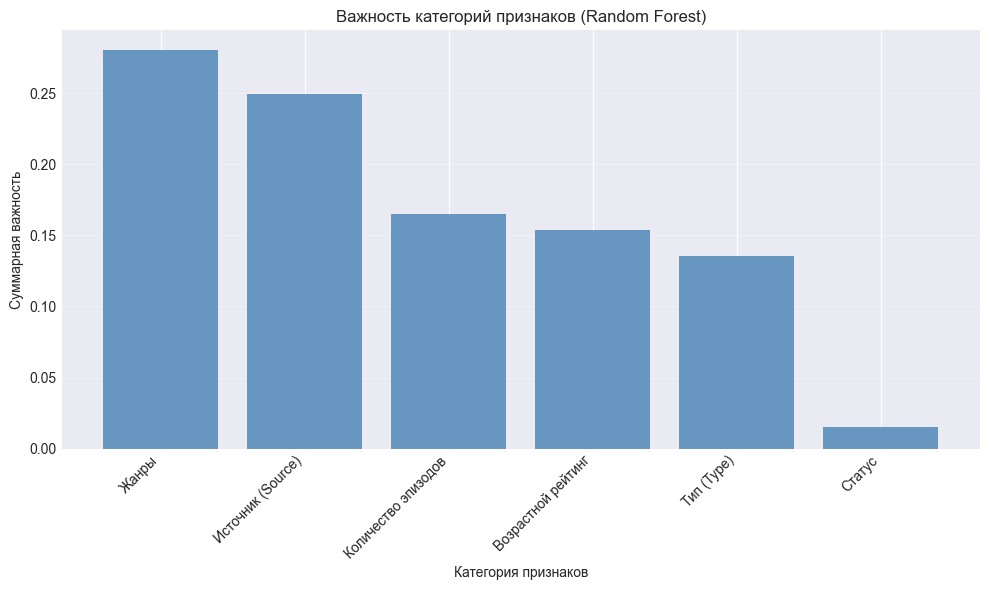

✓ График сохранен


In [25]:
# График 2: Важность категорий признаков
plt.figure(figsize=(10, 6))
categories = category_importance['Category'].tolist()
importances = category_importance['Importance'].tolist()

plt.bar(categories, importances, alpha=0.8, color='steelblue')
plt.xlabel('Категория признаков')
plt.ylabel('Суммарная важность')
plt.title('Важность категорий признаков (Random Forest)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('category_importance_pre_release.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ График сохранен")

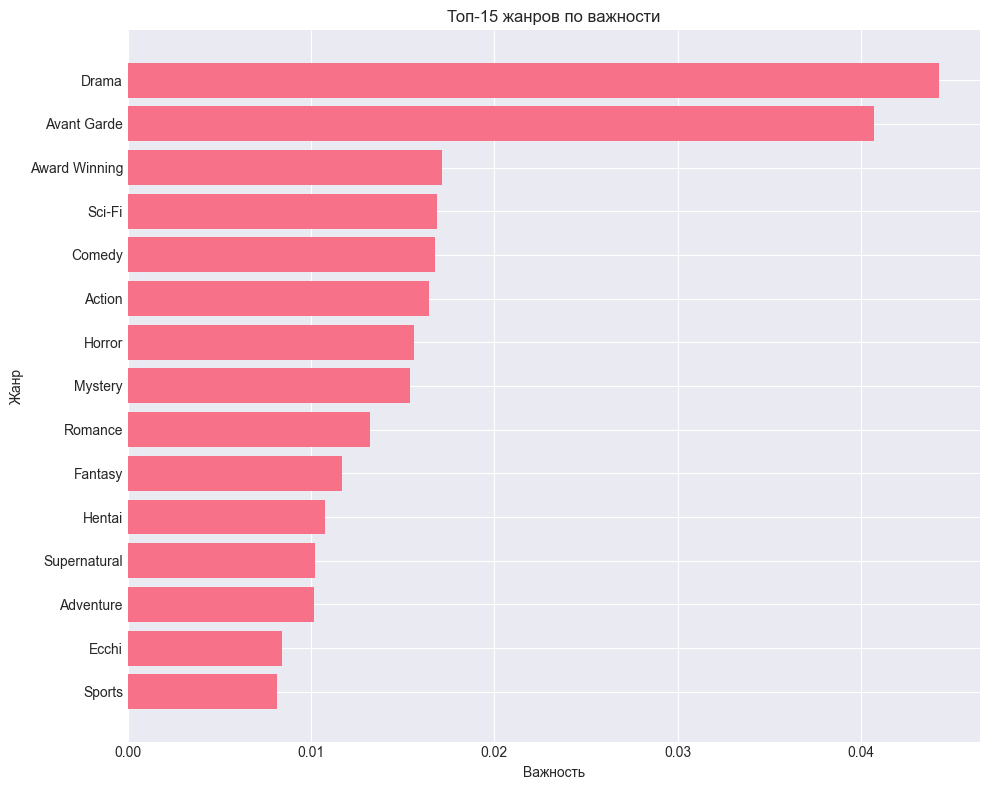

✓ График сохранен


In [26]:
# График 3: Топ жанров по важности
top_genre_features = feature_importance[feature_importance['feature'].str.startswith('Genre_')].head(15)

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_genre_features)), top_genre_features['importance'])
plt.yticks(range(len(top_genre_features)), 
           [f.replace('Genre_', '') for f in top_genre_features['feature']])
plt.xlabel('Важность')
plt.ylabel('Жанр')
plt.title('Топ-15 жанров по важности')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('top_genres_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ График сохранен")

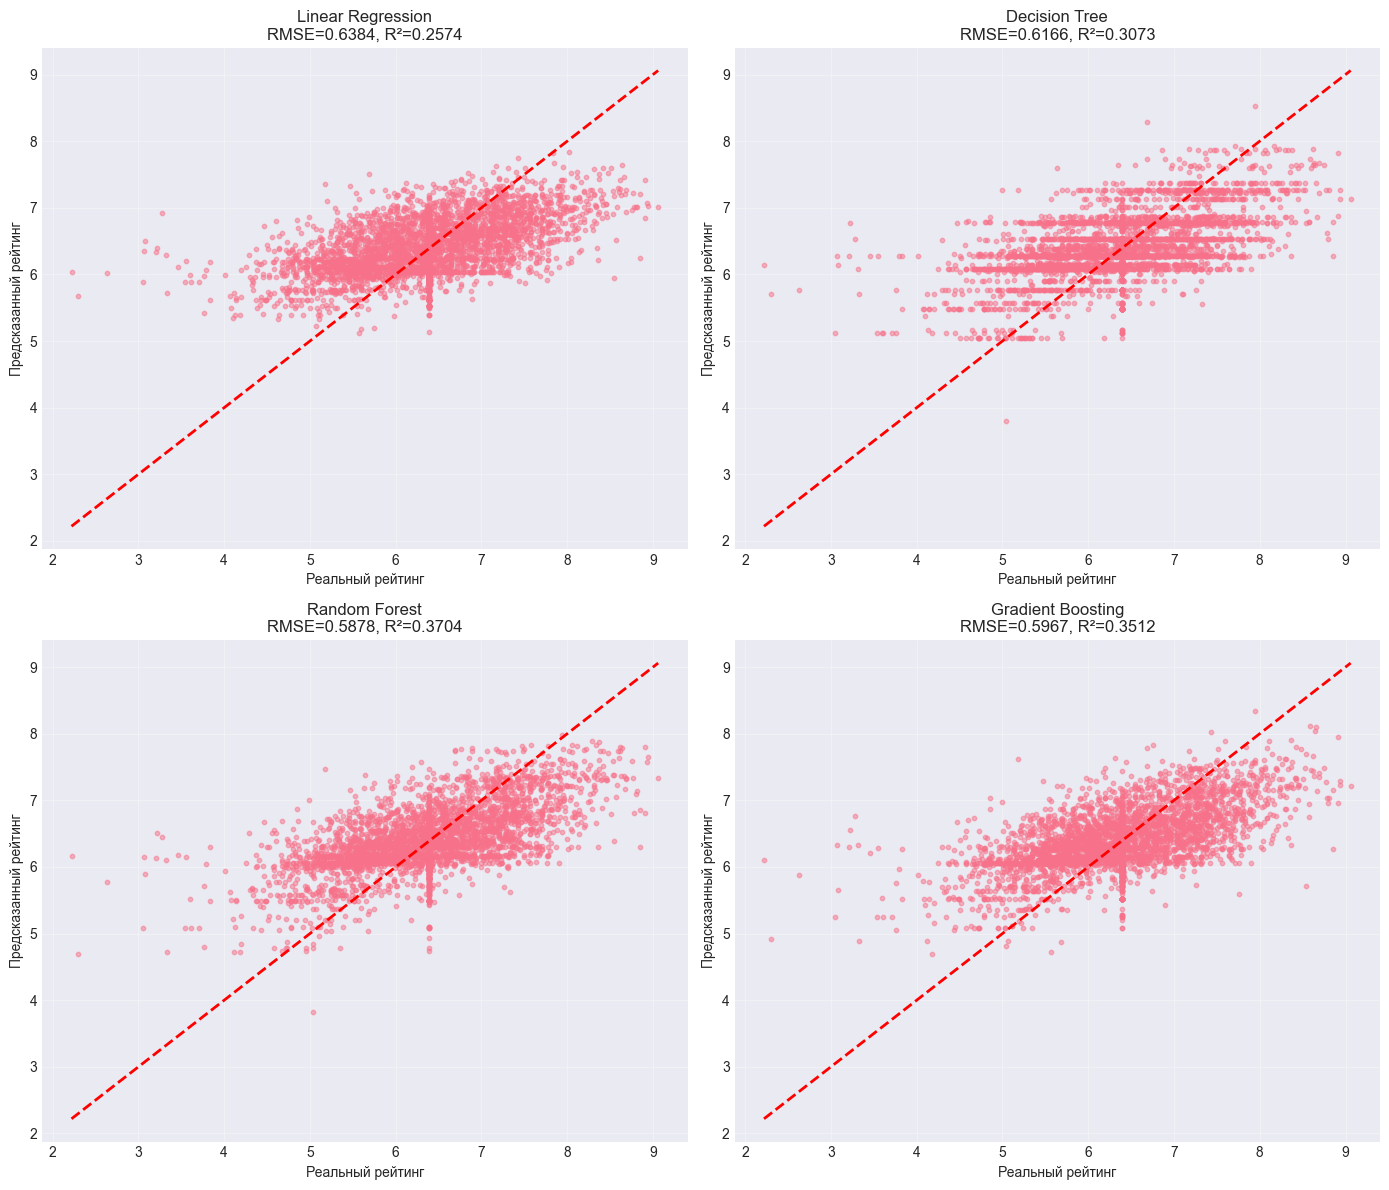

✓ График сохранен


In [27]:
# График 4: Предсказания vs реальные значения
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for idx, (name, result) in enumerate(results.items()):
    row = idx // 2
    col = idx % 2
    ax = axes[row, col]
    
    y_pred = result['predictions']
    ax.scatter(y_test, y_pred, alpha=0.5, s=10)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Реальный рейтинг')
    ax.set_ylabel('Предсказанный рейтинг')
    ax.set_title(f'{name}\nRMSE={result["rmse_test"]:.4f}, R²={result["r2_test"]:.4f}')
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('predictions_vs_actual_pre_release.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ График сохранен")

## 12. Сравнение с Экспериментом 1

In [28]:
# Загружаем результаты первого эксперимента
exp1_results = pd.read_csv('results_full_features.csv')

comparison = pd.DataFrame({
    'Model': results.keys(),
    'Exp1_RMSE': exp1_results['RMSE_Test'].values,
    'Exp2_RMSE': [results[m]['rmse_test'] for m in results.keys()],
    'Exp1_R2': exp1_results['R2_Test'].values,
    'Exp2_R2': [results[m]['r2_test'] for m in results.keys()],
    'RMSE_Diff': [results[m]['rmse_test'] - exp1_results.loc[i, 'RMSE_Test'] 
                  for i, m in enumerate(results.keys())],
    'R2_Diff': [results[m]['r2_test'] - exp1_results.loc[i, 'R2_Test'] 
                for i, m in enumerate(results.keys())]
})

print("Сравнение Эксперимент 1 (Full) vs Эксперимент 2 (Pre-Release):")
comparison

Сравнение Эксперимент 1 (Full) vs Эксперимент 2 (Pre-Release):


,Model,Exp1_RMSE,Exp2_RMSE,Exp1_R2,Exp2_R2,RMSE_Diff,R2_Diff
0,Linear Regression,0.595663,0.638397,0.353483,0.257390,0.042734,-0.096093
1,Decision Tree,0.194376,0.616575,0.931156,0.307291,0.422199,-0.623866
2,Random Forest,0.168938,0.587816,0.947997,0.370404,0.418879,-0.577593
3,Gradient Boosting,0.169209,0.596694,0.947829,0.351242,0.427485,-0.596587


---

## Выводы по Эксперименту 2

### 1. Качество моделей

**Лучшая модель:** Random Forest
- **RMSE:** 0.5878 (средняя ошибка ~0.59 балла)
- **MAE:** 0.4175 (типичное отклонение ~0.42 балла)
- **R²:** 0.3704 (модель объясняет 37% дисперсии рейтинга)

**Результаты всех моделей:**
1. **Random Forest** показал лучшие результаты (R² = 0.37)
2. **Gradient Boosting** близкий второй (R² = 0.35)
3. **Decision Tree** (R² = 0.31)
4. **Linear Regression** (R² = 0.26)

### 2. Сравнение с Экспериментом 1

**Ухудшение качества (как и ожидалось):**
- **RMSE:** вырос с 0.169 до 0.588 (+0.419, в **3.5 раза**)
- **R²:** снизился с 0.948 до 0.370 (-0.578)

**Это ожидаемо**, так как мы не используем важные пост-релизные метрики:
- Rank (78.6% важности в Exp 1)
- Scored By (15.7% важности в Exp 1)
- Members, Favorites, Popularity

### 3. Важность pre-release признаков

**Наиболее важные признаки (Random Forest):**
1. **Episodes** (16.5%) - количество эпизодов
2. **Rating_encoded** (15.4%) - возрастной рейтинг
3. **Source_Manga** (13.9%) - источник из манги
4. **Type_TV** (4.6%) - ТВ-сериал
5. **Genre_Drama** (4.4%) - жанр драма

**По категориям:**
1. **Жанры:** 28.03% (наибольший вклад!)
2. **Источник материала:** 24.93%
3. **Количество эпизодов:** 16.53%
4. **Возрастной рейтинг:** 15.39%
5. **Тип контента:** 13.58%
6. **Статус:** 1.54%

### 4. Ключевые находки

**Жанры критически важны для pre-release оценки:**
- Жанры вносят почти треть (28%) в предсказательную способность
- Drama, Action, Fantasy, Award Winning - ключевые жанры
- Правильная комбинация жанров важнее количества

**Количество эпизодов имеет нелинейное влияние:**
- 12-26 эпизодов - оптимальный диапазон
- Длинные сериалы (>100) склонны к более низким оценкам
- Фильмы (1 эпизод) часто получают выше рейтинг

**Источник материала важен:**
- Адаптации манги/light novel имеют преимущество
- Original работы более непредсказуемы
- Наличие фанбазы источника снижает риски

**Возрастной рейтинг влияет на восприятие:**
- PG-13 - наиболее массовая категория
- R-17+ для нишевой аудитории
- Соответствие рейтинга жанрам важно

### 5. Практическое применение

**Для студий и продюсеров:**
- Модель может оценить потенциал проекта ДО производства
- Помогает принимать решения о зеленом свете
- Указывает на оптимальные параметры (жанры, длительность)

**Рекомендации по повышению ожидаемого рейтинга:**
1. Выбрать популярную комбинацию жанров (Drama+Action/Fantasy)
2. Планировать 12-26 эпизодов (оптимум)
3. Адаптировать известную мангу/light novel
4. Соответствие возрастного рейтинга контенту

**Для платформ и инвесторов:**
- Предварительная оценка перспективности лицензирования
- Приоритизация проектов с высоким предсказанным рейтингом (>6.5)
- Оценка рисков инвестиций

### 6. Ограничения

**Умеренная предсказательная способность:**
- R² = 0.37 означает, что 63% дисперсии определяется другими факторами
- Не учитывается качество сценария, анимации, саундтрека
- Талант создателей (режиссер, автор) не отражен в данных

**Не включены важные признаки:**
- Информация о студии (требует отдельного кодирования)
- Репутация создателей
- Бюджет производства
- Маркетинговые усилия

**Жанры - грубая категоризация:**
- Не отражает нюансы и качество исполнения
- Одна и та же комбинация может дать разные результаты
- Зависит от мастерства сценаристов и режиссеров

### 7. Выводы

**Гипотеза о предсказуемости pre-release частично подтверждена:**
- ✅ 37% дисперсии объясняется доступными признаками
- ✅ Жанры, тип, источник и длительность - значимые факторы
- ⚠️ Но 63% зависит от факторов вне структурированных данных

**Модель превосходит случайное угадывание:**
- Baseline (средняя оценка) имела бы R² ≈ 0
- R² = 0.37 - существенное улучшение
- MAE = 0.42 приемлемо для грубой оценки

**Практическая ценность:**
- Модель не заменяет экспертную оценку
- Служит дополнительным инструментом для принятия решений
- Помогает количественно оценить риски и потенциал
- Наиболее полезна для сравнения альтернативных концепций

**Направления улучшения:**
- Добавить данные о студиях и создателях
- Включить temporal features (тренды жанров)
- NLP анализ синопсисов
- Ensemble с пост-релизной моделью для адаптивных предсказаний